In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np

import matplotlib.pyplot as plt

In [2]:
X, y = make_classification(
    n_samples=1000,
    weights=[0.99],
    random_state=100
)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

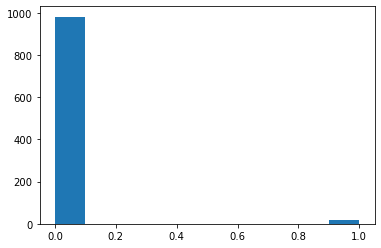

In [3]:
plt.hist(y)
plt.show()

brier score for the 0-skill model

In [4]:
prob_arr = [0.01 for _ in range(y_test.shape[0])]
brier_ref = brier_score_loss(y_test, prob_arr)
print("Brier score for 0-skill classifier model, for P(class1=0) is {}".format(round(brier_ref, 5)))

prob_arr = [1.0 for _ in range(y_test.shape[0])]
brier_ref = brier_score_loss(y_test, prob_arr)
print("Brier score for 0-skill classifier model, for P(class1=1) is {}".format(round(brier_ref, 5)))

Brier score for 0-skill classifier model, for P(class1=0) is 0.0148
Brier score for 0-skill classifier model, for P(class1=1) is 0.985


define the brier skill score

In [5]:
def bss(y_test, prob_arr):
    ref_prob_arr = [0.01 for _ in range(y_test.shape[0])]
    brier_ref = brier_score_loss(y_test, ref_prob_arr)
    brier_score = brier_score_loss(y_test, prob_arr)
    return round(1-(brier_score/brier_ref), 5)

bss_scorer = make_scorer(bss, needs_proba=True)

lets see the perfect bss

In [6]:
print("Perfect BSS is {}".format(bss(y_test, y_test)))

Perfect BSS is 1.0


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Testing Brier score for SVC

In [8]:
svc = SVC(probability=True)
svc.fit(X_train, y_train)
pred_prob = svc.predict_proba(X_test)
print(svc.classes_)
print("Brier skill score for SVM classifier model is {}".format(bss(y_test, pred_prob[:, 1])))

[0 1]
Brier skill score for SVM classifier model is 0.07367


In [9]:
print(y_test[:5], pred_prob[:5, 1])

[0 0 0 0 0] [0.00634511 0.00379072 0.00745027 0.00784967 0.00158395]


In [10]:
print(y_test[y_test == 1], "\n", pred_prob[y_test == 1])

[1 1 1] 
 [[0.99368029 0.00631971]
 [0.98972813 0.01027187]
 [0.77832129 0.22167871]]


Testing BSS for kNN

In [11]:
knc = KNeighborsClassifier()

knc_param_dict = {
    "n_neighbors":[i for i in range(1, 11)],
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "leaf_size": [i for i in range(10, 100, 10)],
    "p": [i for i in range(1, 11)]
}
cv_model = GridSearchCV(estimator=knc, param_grid=knc_param_dict, scoring=bss_scorer, n_jobs=2)
cv_model.fit(X_train, y_train)
best_knc = cv_model.best_estimator_
best_knc.fit(X_train, y_train)
pred_prob = best_knc.predict_proba(X_test)
print(best_knc.classes_)

# print("Brier skill score for KNN classifier model is {}".format(bss(y_test, pred_prob[:, 1])))

[0 1]


In [12]:
print("Best model params are \n{}\n\n".format(cv_model.best_params_))
print("Brier skill score for KNN classifier model is {}".format(cv_model.best_score_))

Best model params are 
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}


Brier skill score for KNN classifier model is 0.092338


In [13]:
import pandas as pd
from IPython.display import display

df = pd.DataFrame(cv_model.cv_results_)
display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003880,0.001012,0.015985,0.001233,auto,10,1,1,uniform,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",-0.69147,-1.36806,-0.01488,-0.69147,-0.27033,-0.607242,0.459877,6697
1,0.003631,0.001448,0.015641,0.004962,auto,10,1,1,distance,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",-0.69147,-1.36806,-0.01488,-0.69147,-0.27033,-0.607242,0.459877,6697
2,0.002036,0.000280,0.007675,0.000435,auto,10,1,2,uniform,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",-1.36806,-1.02977,-0.01488,-1.02977,-0.77846,-0.844188,0.455059,7129
3,0.002082,0.000255,0.009793,0.001054,auto,10,1,2,distance,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",-1.36806,-1.02977,-0.01488,-1.02977,-0.77846,-0.844188,0.455059,7129
4,0.002117,0.000464,0.153002,0.030878,auto,10,1,3,uniform,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",-1.02977,-0.69147,-0.01488,-0.69147,-0.77846,-0.641210,0.336796,6769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.001600,0.001186,0.176890,0.003101,brute,90,10,8,distance,"{'algorithm': 'brute', 'leaf_size': 90, 'n_nei...",-0.09778,-0.13362,0.29703,-0.00715,-0.05045,0.001606,0.153770,2341
7196,0.001532,0.001061,0.175715,0.002493,brute,90,10,9,uniform,"{'algorithm': 'brute', 'leaf_size': 90, 'n_nei...",-0.09946,-0.12314,0.27605,-0.01827,-0.04421,-0.001806,0.143897,2665
7197,0.001005,0.000385,0.175447,0.004201,brute,90,10,9,distance,"{'algorithm': 'brute', 'leaf_size': 90, 'n_nei...",-0.10167,-0.12483,0.29615,-0.00769,-0.04631,0.003130,0.152170,2197
7198,0.000746,0.000180,0.175889,0.002374,brute,90,10,10,uniform,"{'algorithm': 'brute', 'leaf_size': 90, 'n_nei...",-0.09608,-0.12652,0.27605,-0.01827,-0.04675,-0.002314,0.144177,2737


# Imbalanced Datasets

The [credit card fraud detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset will be used \
The **Class** column in the dataset indicates whether the card is fraud or not.


In [14]:
!pip install imbalanced-learn

You should consider upgrading via the '/home/laferrari/anaconda3/envs/tensorflow_cpu/bin/python -m pip install --upgrade pip' command.


In [ ]:
import os
zipPath = ""
for fileName in os.listdir("./"):
    if fileName.endswith(".zip"):
        zipPath = os.path.relpath(fileName)
!unzip {zipPath}

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import display

df = pd.read_csv("./creditcard.csv")
display(df.head())

print(df.dtypes)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


firstly, it is clear that no categorical encoding is needed since all variables are either continuous or discrete

In [16]:
print(df.shape)

(284807, 31)


In [17]:
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Good, so no null values are present in this dataset

In [18]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Hence positive classes are so many, and negative classes are so less compared to them.

In [19]:
x, y = df.drop("Class", axis=1), df['Class']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

In [ ]:
# plot the values
fig = plt.figure()
fig.set_figheight(60)

for i in range(1, 29, 1):
    ax = fig.add_subplot(28, 1, i)
    df[df['Class'] == 0]['V'+str(i)].plot(kind='kde', ax=ax, color='red') # kde - kernel density estimator
    df[df['Class'] == 1]['V'+str(i)].plot(kind='kde', ax=ax, color='blue')
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, GridSearchCV

lc = LogisticRegression()
grid = {
    'C': 10.0**np.arange(-2, 3),
    'penalty': ['l1', 'l2'] # regularisation method
}
cv = KFold(n_splits=5, shuffle=False, random_state=42)

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [21]:
gS = GridSearchCV(
    lc,
    grid,
    n_jobs=2,
    cv=cv,
    scoring='f1_macro'
)
gS.fit(x_train.values, y_train.values)

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [22]:
clf = gS.best_estimator_
y_pred = clf.predict(x_test.values)
print("accuracy = ", accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

accuracy =  0.9990637032875719
[[85258    35]
 [   45   105]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85293
           1       0.75      0.70      0.72       150

    accuracy                           1.00     85443
   macro avg       0.87      0.85      0.86     85443
weighted avg       1.00      1.00      1.00     85443



AUC-ROC score for randomforest classifier is: 0.8497948248977055
Threshold value shape for random forest classifier is:  (326,) fpr shape is (326,)


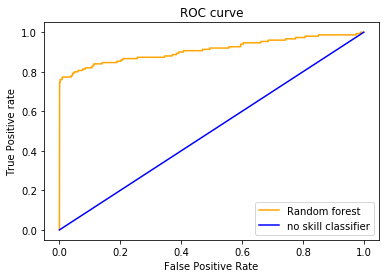

In [26]:
pred_prob_logR_cv = clf.predict_proba(x_test.values)

from sklearn.metrics import roc_auc_score, roc_curve

print("AUC-ROC score for randomforest classifier is:", roc_auc_score(y_test, y_pred, average=None))

fpr_logR_cv, tpr_logR_cv, thresh_logR_cv = roc_curve(y_test, pred_prob_logR_cv[:,1])

print("Threshold value shape for random forest classifier is: ", thresh_logR_cv.shape, 
      "fpr shape is", fpr_logR_cv.shape
     )

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

plt.plot(fpr_logR_cv, tpr_logR_cv, color='orange', label='LogReg with gridSearch')
plt.plot(p_fpr, p_tpr, color='blue', label='no skill classifier')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

Its usually believed that imbalanced dataset does not heavily impact the decision-trees and random-forest ensemble techniques

In [27]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc = RFC()
rfc.fit(x_train.values, y_train.values)

y_pred_rfc = rfc.predict(x_test.values)
pred_prob_rfc = rfc.predict_proba(x_test)

print("accuracy = ", accuracy_score(y_pred_rfc, y_test))
print(confusion_matrix(y_test, y_pred_rfc))
print()
print(classification_report(y_test, y_pred_rfc))

accuracy =  0.9995084442259752
[[85287     6]
 [   36   114]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85293
           1       0.95      0.76      0.84       150

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



AUC-ROC score for randomforest classifier is: 0.879964827125321
Threshold value shape for random forest classifier is:  (61,) fpr shape is (61,)


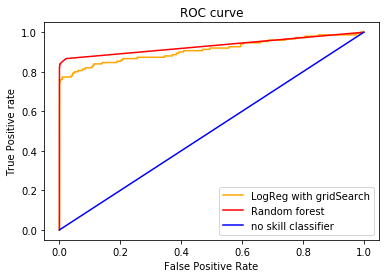

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve
print("AUC-ROC score for randomforest classifier is:", roc_auc_score(y_test, y_pred_rfc, average=None))

fpr_rfc, tpr_rfc, thresh_rfc = roc_curve(y_test, pred_prob_rfc[:,1])

print("Threshold value shape for random forest classifier is: ", thresh_rfc.shape, 
      "fpr shape is", fpr_rfc.shape
     )

plt.plot(fpr_logR_cv, tpr_logR_cv, color='orange', label='LogReg with gridSearch')
plt.plot(fpr_rfc, tpr_rfc, color='red', label='Random forest')
plt.plot(p_fpr, p_tpr, color='blue', label='no skill classifier')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

# Under-sampling

* reduce the total number of samples for the class that the distribution is biased towards, i.e. the class having many more samples than some other class(es)
* should be used when the ratio is too skewed, i.e. extent of imbalance in the dataset is a lot.
* <font color="red">major disadvantage</font> = useful information in the majority class samples might get thrown away.
* for NearMiss method of under sampling
    * $\alpha = \frac{\textrm{N}_{\textrm{m}}}{\textrm{N}_{\textrm{rM}}}$, is the value being provided as a parameter to the function call of NearMiss
    * $\textrm{N}_{\textrm{m}}$ = number of samples in the minority class after under sampling\
    $\textrm{N}_{\textrm{rM}}$ = number of samples in the Majority class after under sampling

In [29]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(0.8) # reduce to 80% of original data
x_train_new, y_train_new = nm.fit_sample(x_train, y_train)
print(y_train_new.value_counts())

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy=0.8 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


0    427
1    342
Name: Class, dtype: int64


accuracy =  0.8260243671219409
[[70442 14851]
 [   14   136]]

              precision    recall  f1-score   support

           0       1.00      0.83      0.90     85293
           1       0.01      0.91      0.02       150

    accuracy                           0.83     85443
   macro avg       0.50      0.87      0.46     85443
weighted avg       1.00      0.83      0.90     85443

0.8662746063569109
Threshold value for random forest classifier, with under sampling is:  (102,) fpr shape is (102,)


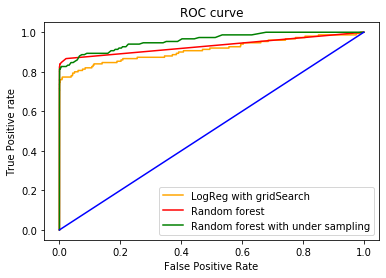

In [30]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc = RFC()
rfc.fit(x_train_new.values, y_train_new.values)

y_pred_underSampling_rfc = rfc.predict(x_test.values)
pred_prob_underSampling_rfc = rfc.predict_proba(x_test)

print("accuracy = ", accuracy_score(y_pred_underSampling_rfc, y_test))
print(confusion_matrix(y_test, y_pred_underSampling_rfc))
print()
print(classification_report(y_test, y_pred_underSampling_rfc))

from sklearn.metrics import roc_auc_score, roc_curve
print(roc_auc_score(y_test, y_pred_underSampling_rfc, average=None))

fpr_underSampling_rfc, tpr_underSampling_rfc, thresh_underSampling_rfc = roc_curve(y_test, pred_prob_underSampling_rfc[:,1])

print("Threshold value for random forest classifier, with under sampling is: ", thresh_underSampling_rfc.shape, 
      "fpr shape is", fpr_underSampling_rfc.shape
     )

plt.plot(fpr_logR_cv, tpr_logR_cv, color='orange', label='LogReg with gridSearch')
plt.plot(fpr_rfc, tpr_rfc, color='red', label='Random forest')
plt.plot(fpr_underSampling_rfc, tpr_underSampling_rfc, color='green', label='Random forest with under sampling')
plt.plot(p_fpr, p_tpr, color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

* ROC is kind of maintained
* <font color="red">Accuracy is reduced a lot.</font>
* <font color="red">precision has slid down to 0</font>

# Over-sampling
* increase the data-points of the minority class
* add copies of data points from the minority class, which amplifies the decision region resulting in the improvement of evaluation metrics.
* <font color="red">major disadvantage</font> - might result in overfitting
* 

In [31]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(0.5)
x_train_new, y_train_new = ros.fit_sample(x_train, y_train)
print(y_train_new.value_counts())

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


0    199022
1     99511
Name: Class, dtype: int64


accuracy =  0.9995084442259752
[[85284     9]
 [   33   117]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85293
           1       0.93      0.78      0.85       150

    accuracy                           1.00     85443
   macro avg       0.96      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443

0.8899472406879815
Threshold value for random forest classifier is:  (59,) fpr shape is (59,)


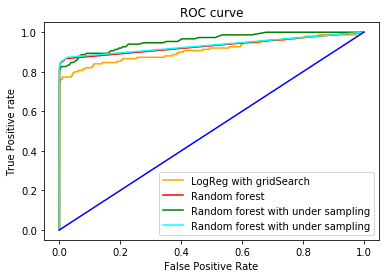

In [32]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc = RFC()
rfc.fit(x_train_new.values, y_train_new.values)

y_pred_rfc_overSampling = rfc.predict(x_test.values)
pred_prob_rfc_overSampling = rfc.predict_proba(x_test)

print("accuracy = ", accuracy_score(y_pred_rfc_overSampling, y_test))
print(confusion_matrix(y_test, y_pred_rfc_overSampling))
print()
print(classification_report(y_test, y_pred_rfc_overSampling))

from sklearn.metrics import roc_auc_score, roc_curve
print(roc_auc_score(y_test, y_pred_rfc_overSampling, average=None))

fpr_rfc_overSampling, tpr_rfc_overSampling, thresh_rfc_overSampling = roc_curve(y_test, pred_prob_rfc_overSampling[:,1])



print("Threshold value for random forest classifier is: ", thresh_rfc_overSampling.shape, 
      "fpr shape is", fpr_rfc_overSampling.shape
     )

plt.plot(fpr_logR_cv, tpr_logR_cv, color='orange', label='LogReg with gridSearch')
plt.plot(fpr_rfc, tpr_rfc, color='red', label='Random forest')
plt.plot(fpr_underSampling_rfc, tpr_underSampling_rfc, color='green', label='Random forest with under sampling')
plt.plot(fpr_rfc_overSampling, tpr_rfc_overSampling, color='cyan', label='Random forest with under sampling')
plt.plot(p_fpr, p_tpr, color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

* With about the same accuracy as that of taking the entire training data
* randomOverSampler actually reduced the total number of false-positives(type-1 error) from 6(in entire train-data) to 3(in randomly oversampled train-data), 
* and also increased the total number of true-positives from 85286(in entire train-data) to 85289(in RandomlyOverSampled train-data)
* and the AUC-ROC value has increased from 0.72 to 0.86

# SMOTETomek
1. Class to perform over-sampling using SMOTE and cleaning using Tomek links.
2. Combine over- and under-sampling using SMOTE and Tomek links.

# SMOTE
* SMOTE - Synthetic Minority Oversampling TEchnique
* this reduces the overfitting issue faced in oversampling
* enhanced sampling method that creates synthetic samples based on the nearest neighbors of feature values in the minority class.
* smote-generated(**synthesized samples**) sample s = x + u.(x$^{\textrm{R}}$-x), where x$^{\textrm{R}}$ is randomly chosen among the 5  minority class nearest neighbors of sample x
    * the sample x will have some sort of a distribution w.r.t. each feature
    * correspondingly, sample x$^{\textrm{R}}$ will also have some distribution
    * for both of these distributions, the expected value E(.) and variance var(.) is assumed to be the same, <font color="green">but this holds true only for **high-dimensional** , imbalanced datasets </font>
    * <font color="red">For ***low-dimensional*** imbalanced dataset, since samples are correlated, this assumption doesn't hold true.</font>
* hence, for SMOTE samples, E$\left(\textrm{X}_{\textrm{j}}^{\textrm{smote}}\right)$ = E$\left(\textrm{X}_{\textrm{j}} \right)$, and $\sigma^{\textrm{2}}\left(\textrm{X}_{\textrm{j}}^{\textrm{smote}}\right) \, = \, \frac{2}{3} \sigma^{\textrm{2}}\left(\textrm{X}_{\textrm{j}}\right)$ 
* SMOTE has little impact on the classifiers that base their classification rules on class-specific mean values and overall variances (as DLDA - diagonal linear discriminant analysis), while it has some (harmful) impact on the classifiers that use class-specific variances (as DQDA - diagonal Quadratic discriminant analysis), because they use biased estimates.
* <img src="smote_vis.png" />
* the bigger red-circles are the actual minority samples that already existed in the dataset, the smaller red circles are the ones that are added as a result of SMOTE
* SMOTE *imagines* synthetic samples to be along these lines joining the actual minority-class samples
* the above image that shows SMOTE samples being generated just from 2 feautres is just for visualisation simplicity, in reality, all features need to be considered for generating SMOTE samples.


* <img src="smote_synthesis_1.png" />
* In the above example, K = 1(number of nearest neighbors to be used for smote-sample-synthesis, the parameter name in the actual `imblearn.over_sampling.SMOTE function` is `k_neighbors` )
    * hence a new sample is synthesized on the line joining these 2 points


* <img src="smote_synthesis_2.png" />
* at K = 2
    * both the nearest neighbors are considered.
    * For each new synthesis, a new one is randomly chosen between them.
* At each loop iteration, one of the K closest minority class neighbours is chosen and a new minority instance is synthesised somewhere between the minority instance and that neighbour.


# Tomek
* Class to perform under-sampling by removing Tomek’s links.


In [33]:
from imblearn.combine import SMOTETomek

sm = SMOTETomek(0.5)
x_train_new, y_train_new = sm.fit_sample(x_train, y_train)
print(y_train_new.value_counts())

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


0    198168
1     98657
Name: Class, dtype: int64


accuracy =  0.9994265182636377
[[85272    21]
 [   28   122]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85293
           1       0.85      0.81      0.83       150

    accuracy                           1.00     85443
   macro avg       0.93      0.91      0.92     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC value = 0.90654356160529
Threshold value for random forest classifier is:  (61,) fpr shape is (61,)


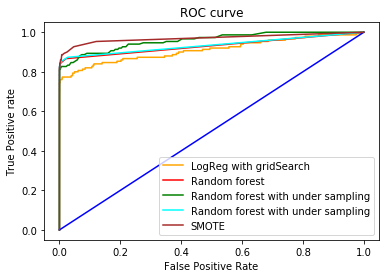

In [34]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc = RFC(n_jobs=-1)
rfc.fit(x_train_new.values, y_train_new.values)

y_pred_rfc_smotetomek = rfc.predict(x_test.values)
pred_prob_rfc_smotetomek = rfc.predict_proba(x_test)

print("accuracy = ", accuracy_score(y_pred_rfc_smotetomek, y_test))
print(confusion_matrix(y_test, y_pred_rfc_smotetomek))
print()
print(classification_report(y_test, y_pred_rfc_smotetomek))

from sklearn.metrics import roc_auc_score, roc_curve
print("AUC-ROC value =", roc_auc_score(y_test, y_pred_rfc_smotetomek, average=None))

fpr_rfc_smotetomek, tpr_rfc_smotetomek, thresh_rfc_smotetomek = roc_curve(y_test, pred_prob_rfc_smotetomek[:,1])


print("Threshold value for random forest classifier is: ", thresh_rfc_smotetomek.shape, 
      "fpr shape is", fpr_rfc_smotetomek.shape
     )

plt.plot(fpr_logR_cv, tpr_logR_cv, color='orange', label='LogReg with gridSearch')
plt.plot(fpr_rfc, tpr_rfc, color='red', label='Random forest')
plt.plot(fpr_underSampling_rfc, tpr_underSampling_rfc, color='green', label='Random forest with under sampling')
plt.plot(fpr_rfc_overSampling, tpr_rfc_overSampling, color='cyan', label='Random forest with under sampling')
plt.plot(p_fpr, p_tpr, color='blue')


plt.plot(fpr_rfc_smotetomek, tpr_rfc_smotetomek, color='brown', label='SMOTE')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

* AUC-ROC value is greater than oversampler
* recall and f1-score are greater , but <font color="red">precision is lower</font> than oversampler
* 

# ADASYN
* inspired by SMOTE, He et. al. in 2009, introduced a method called adaptive synthetic sampling, that received wide attention.
* ADASYN generates samples of the minority class according to their density distributions. 
* More synthetic data is generated for minority class samples that are harder to learn, compared to those minority samples that are easier to learn. 
* It calculates the K-nearest neighbors of each minority instance, then gets the class ratio of the minority and majority instances to generate new samples. 
* By repeating this process, it adaptively shifts the decision boundary to focus on those samples that are difficult to learn.

In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(0.8)
x_train_new, y_train_new = adasyn.fit_sample(x_train, y_train)
print(y_train_new.value_counts())

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc = RFC(n_jobs=-1)
rfc.fit(x_train_new.values, y_train_new.values)

y_pred = rfc.predict(x_test.values)
pred_prob2 = rfc.predict_proba(x_test)

print("accuracy = ", accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score, roc_curve
print("AUC-ROC value =", roc_auc_score(y_test, y_pred, average=None))

fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1])

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

print("Threshold value for random forest classifier is: ", thresh2.shape, 
      "fpr shape is", fpr2.shape
     )

plt.plot(fpr1, tpr1, color='orange', label='over sampler')
plt.plot(fpr2, tpr2, color='green', label='SMOTE')
plt.plot(p_fpr, p_tpr, color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

# Ensemble-techniques
* don't get confused with sklearn ensembles, here we are actually using ensembles from **imblearn** module

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier

easy = EasyEnsembleClassifier()
easy.fit(x_train, y_train)

y_pred = easy.predict(x_test.values)
pred_prob3 = easy.predict_proba(x_test)

print("accuracy = ", accuracy_score(y_pred, y_test))
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score, roc_curve
print("AUC-ROC value =", roc_auc_score(y_test, y_pred, average=None))

fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1])

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

print("Threshold value for random forest classifier is: ", thresh3.shape, 
      "fpr shape is", fpr3.shape
     )

plt.plot(fpr1, tpr1, color='orange', label='over sampler')
plt.plot(fpr2, tpr2, color='green', label='SMOTE')
plt.plot(fpr3, tpr3, color='red', label='easy ensemble classifier')
plt.plot(p_fpr, p_tpr, color='blue')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()